# 04.4 - Retrieval Augmented Generation using OpenAI

https://github.com/deepset-ai/haystack-tutorials/tree/main/tutorials

In [ ]:
from IPython.display import Markdown
import os
import warnings
from langchain_community.document_loaders import PyPDFLoader
#Imports for RAG Pipeline and Document Store
from haystack import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
#Imports for Chat Approach
from haystack.components.generators.utils import print_streaming_chunk
from haystack import Pipeline

warnings.filterwarnings("ignore")

os.environ["OPENAI_API_KEY"] = ""

In [2]:
#https://eur-lex.europa.eu/legal-content/EN/TXT/PDF/?uri=OJ:L_202401689
# Save as AI_act_EN.pdf

loader = PyPDFLoader("./AI_act_EN.pdf")
pages = loader.load_and_split()
print("Size of DOC: \n", len(pages))

Size of DOC: 
 230


In [3]:
#size of documents
range_pages = range(0,len(pages))

#Define a DocStore 
document_store = InMemoryDocumentStore()

#Convert to Haystack Docs
docs = [Document(content=pages[i].page_content, meta=pages[i].metadata) for i in range_pages]

#Embedd documents
doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2", normalize_embeddings=True)
doc_embedder.warm_up()

docs_with_embeddings = doc_embedder.run(docs)

print("Embedding size: ", len(docs_with_embeddings['documents'][0].embedding))

#Write documents -> Ids, Content and embeddings
document_store.write_documents(docs_with_embeddings["documents"])

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Embedding size:  384


230

In [16]:
template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""
#Define pipeline components
pipe_comp = [
    ('text_embedder', SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2", normalize_embeddings=True)),
    ('retriever', InMemoryEmbeddingRetriever(document_store=document_store, scale_score=True)),
    # You can rank retrieved documents with with a Ranker, but we will skip this step for now
    ('prompt_builder', PromptBuilder(template=template)),
    ('llm', OpenAIGenerator(model="gpt-4o", generation_kwargs={'temperature': 0.1}))
]

#Define pipeline
basic_rag_pipeline = Pipeline()

#1. Add components
for comp in pipe_comp:
    basic_rag_pipeline.add_component(*comp)


# #2. Connect components
# #LOGIC: Output -> Input
basic_rag_pipeline.connect('text_embedder.embedding', "retriever.query_embedding")
basic_rag_pipeline.connect('retriever', 'prompt_builder.documents')
basic_rag_pipeline.connect('prompt_builder', 'llm')

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

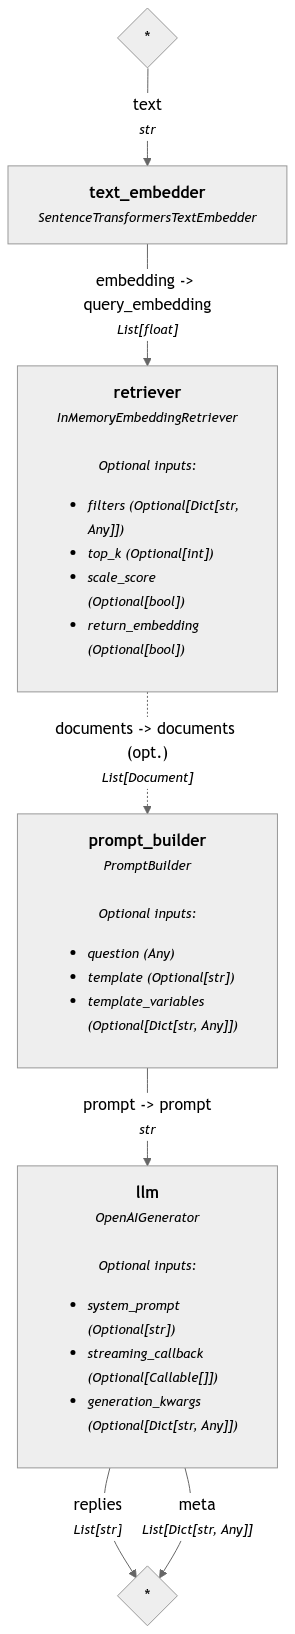

In [17]:
basic_rag_pipeline.show()

In [18]:
question = "What are the main dangers from AI?"

query = {
    'text_embedder': {
        'text': question
    },

    'prompt_builder': {
        'question': question
    }
}

response = basic_rag_pipeline.run(query)
Markdown(response['llm']['replies'][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The main dangers from AI, as outlined in the provided context, include:

1. **Subliminal and Manipulative Techniques**: AI systems that deploy subliminal techniques beyond a person's consciousness or use manipulative or deceptive techniques to distort behavior and impair decision-making, potentially causing significant harm.

2. **Exploitation of Vulnerabilities**: AI systems that exploit vulnerabilities of individuals or groups due to age, disability, or specific social or economic situations, leading to behavior distortion and potential harm.

3. **Social Scoring**: AI systems used for evaluating or classifying individuals based on social behavior or personal characteristics, leading to detrimental or unfavorable treatment in unrelated social contexts.

4. **Predictive Risk Assessments**: AI systems used for making risk assessments of individuals, particularly in predicting criminal behavior based solely on profiling or personality traits, which can lead to unjustified or disproportionate treatment.

5. **Facial Recognition and Emotion Inference**: AI systems that create or expand facial recognition databases through untargeted data scraping or infer emotions in sensitive areas like workplaces and educational institutions, except for medical or safety reasons.

6. **Cybersecurity Risks**: AI systems vulnerable to cyberattacks, such as data poisoning or adversarial attacks, which can alter their use, behavior, or performance, compromising security and potentially leading to harmful outcomes.

7. **Bias and Discrimination**: AI systems in education, employment, and access to services that may perpetuate historical patterns of discrimination, affecting individuals' rights and opportunities.

8. **Privacy and Data Protection**: AI systems that undermine privacy and data protection rights, particularly in contexts like employment and migration, where individuals may be in vulnerable positions.

These dangers highlight the potential for AI systems to cause significant harm if not properly regulated and managed, emphasizing the need for robust safeguards and ethical considerations in their deployment and use.